## Week4-Assignment
뉴스 기사를 전처리하여 워드 클라우드 생성하기
1. 텍스트 정제
2. 토크나이징
3. 워드클라우드 생성

```
코드는 자유롭게 수정해도 좋습니다!
```

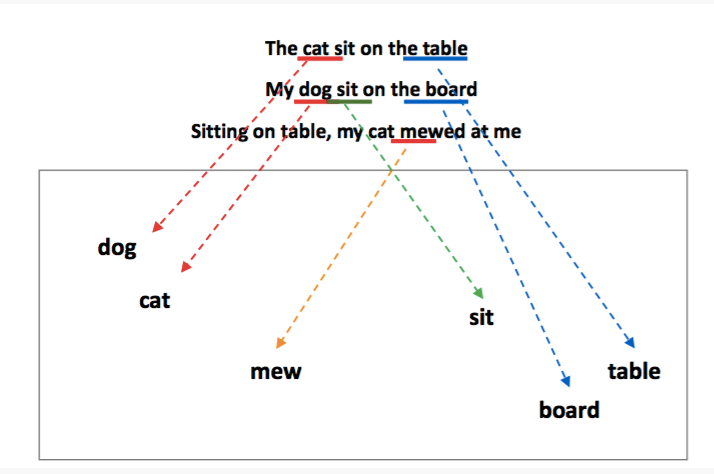

##Doc2Vec

**Word2vec**이 등장한 이후 몇달이 지나지 않아 **Doc2vec**이 등장합니다.
Doc2vec은 하나의 document를 document_id로 생각하고, 이를 하나의 단어처럼 생각합니다.
나의 단어처럼 생각합니다. ‘a little dog sit on the table’ 이란 문장에 해당하는 document id, #doc5 역시 의미공간에서의 위치 좌표를 지닙니다. 그리고 모든 스냅샷에서 다른 단어들의 위치좌표와 함께 평균을 취하여 context vector 를 만듭니다. 그 다음은 Word2Vec 과 같습니다. document id + 4 개의 단어로 이뤄진 context vector 에 가깝도록 Y, cat 의 위치를 조절합니다. 

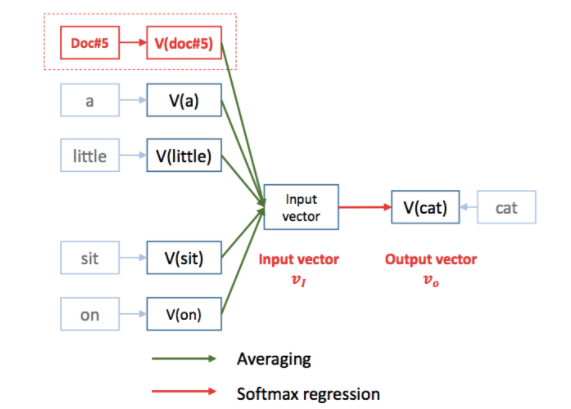

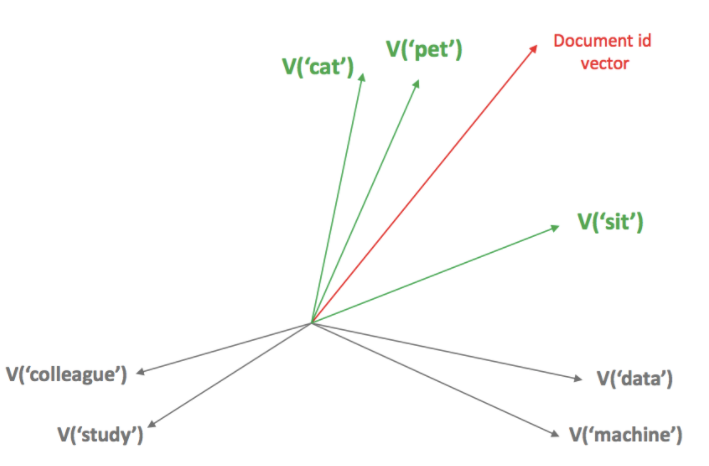

단어가 다르더라도 단어의 벡터들이 비슷하다보니 각 문장의 document vectors 가 비슷해집니다. v(cat) ≃ v(dog), v(table) ≃ v(board) 이기 때문에 v(‘a little cat sit on table’) ≃
 v(‘a little dog sit on board’) 가 됩니다. 이는 entity - descriptor 의 관계로 생각할 수 있습니다. 임베딩을 하고 싶은 entity 에 대하여 이를 기술할 수 있는 단어, 혹은 이와 비슷한 list of descriptor 를 정의할 수 있다면 entity 의 임베딩 벡터를 학습할 수 있습니다.

In [ ]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

!pip install soynlp
!pip install konlpy
!pip install wordcloud
!pip install soynlp

2021-03-27 02:08:36,808 : INFO : generated new fontManager


### A. 한글 기사

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import sklearn

In [2]:
def get_breaking_link():
    url = "https://search.naver.com/search.naver?"

    url_list = []
    #크롤링할 페이지수 
    for i in range(0,300):
      params = {
          # 탭
          "where": 'news',

          # 검색어
          "query": '속보',

          # 페이지
          "start": i,
      }

      response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, params=params)
      soup = BeautifulSoup(response.text, "html.parser")


      for i in soup.select('div.info_group > a'):
          if re.search('news.naver.com', i['href']):
              url_list.append(i['href'])

    return url_list

def get_link(query):
    url = "https://search.naver.com/search.naver?"

    url_list = []
    #크롤링할 페이지수 
    for i in range(0,1):
      params = {
          # 탭
          "where": 'news',

          # 검색어
          "query": query,

          # 페이지
          "start": i,
      }

      response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, params=params)
      soup = BeautifulSoup(response.text, "html.parser")


      for i in soup.select('div.info_group > a'):
          if re.search('news.naver.com', i['href']):
              url_list.append(i['href'])

    return url_list


def get_article(url_list):

    title_list = []
    content_list = []
    for url in url_list:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        try:
          document_content = BeautifulSoup(response.content, "html.parser")
        except Exception as e:
          print(f"crawling failed for url:{url}, Error: {e}")
          continue  
          
        # 기사 제목 가져옴
        tag_headline = document_content.find_all('h3', {'id': 'articleTitle'}, {'class': 'tts_head'})
        text_headline = ''  # 뉴스 기사 제목 초기화
        text_sentence = ''  # 뉴스 기사 본문 초기화
        try:
          # 기사  제목 예시 : [<h3 id="articleTitle">]제목내용</h3>]
          # 필요 없는 내용 날리고 깔끔하게 처리해주기
          text_headline = text_headline + str(tag_headline[0].find_all(text=True))
          if not text_headline:  # 공백일 경우 기사 제외 처리
            continue
          # 기사 본문 가져옴
          tag_content = document_content.find_all('div', {'id': 'articleBodyContents'})
          text_sentence = text_sentence + str(tag_content[0].find_all(text=True))
          if not text_sentence:  # 공백일 경우 기사 제외 처리
            continue
          title_list.append(text_headline)
          content_list.append(text_sentence)
        except Exception as e: 
          print('fail')
    return title_list, content_list

In [3]:
#검색어를 입력해주세요
query1= input("검색어(한글)를 입력해주세요: ")
news_link1 = get_link(query1)
print(news_link1)
print()
news_title1, news_content1 = get_article(news_link1)
#제목이랑 내용이랑 같은 숫자인지 확인
len(news_title1) , len(news_content1)

검색어(한글)를 입력해주세요: 삼성전자실적
['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=009&aid=0004769981', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=374&aid=0000238755', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=015&aid=0004520169', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=052&aid=0001567548', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=016&aid=0001812154', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=277&aid=0004871143', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000690498', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=015&aid=0004518672', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=030&aid=0002935292']



(9, 9)

In [4]:
#속보를 가져옵니다
news_link2 = get_breaking_link()
print(news_link2)
print()
news_title2, news_content2 = get_article(news_link2)
#제목이랑 내용이랑 같은 숫자인지 확인
len(news_title2) , len(news_content2)

['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=015&aid=0004520192', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=009&aid=0004770082', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=087&aid=0000837821', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=629&aid=0000074210', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=088&aid=0000695520', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=005&aid=0001424527', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=023&aid=0003604397', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=215&aid=0000946800', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=004&oid=366&aid=0000691502', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=005&aid=0001424537', 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=015&aid=0004520192', 'https://news.naver.

(2806, 2806)

In [5]:
#두개의 내용을 섞어줍니다

segment = []
news_title = news_title1 + news_title2
news_content = news_content1 + news_content2
for i in range(len(news_title1)):
  segment.append(query1)
for i in range(len(news_title2)):  
  segment.append('속보')

In [6]:
def title_preprocessing(text):
    val_split = text.split(sep='flash_removeCallback() {}\n\n')
    val_split
    text = text.replace('무단 전재 재배포 금지','')
    text = text.replace("\\\\n", "")
    text = text.replace("\\n", "")
    text = text.replace("\n", "")
    text = text.replace("\\", "")
    text = text.replace("\\t", "")
    text = text.replace("NaN", "")
    text = text.replace("  ", " ")
    text = text.replace("\t", "")

    # 한글, english 빼고 전부 날리기
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z|0-9|.|]', ' ', text)
    text = re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》{}_▲▶兆]', '', text)
    return text

def content_preprocessing(text):
    val_split = text.split(sep='flash_removeCallback()')
    text = val_split[1]
    text = text.replace('무단 전재 재배포 금지','')
    text = text.replace("\\\\n", "")
    text = text.replace("\\n", "")
    text = text.replace("\n", "")
    text = text.replace("\\tt", "")
    text = text.replace("\tt", "")
    text = text.replace("\t", "")
    text = text.replace("\\", "")
    text = text.replace("\\t", "")
    text = text.replace("NaN", "")
    text = text.replace("  ", " ")
    text = text.replace("\t", "")

    # 한글, english 빼고 전부 날리기
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z|0-9|.|]', ' ', text)
    text = re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》{}_▲▶兆]', '', text)
    return text

news_list_1 = []
news_list_2 = []

for i in news_title:
    news_list_1.append(title_preprocessing(i))

for i in news_content:    
    news_list_2.append(content_preprocessing(i))

In [7]:
df_merge = pd.DataFrame(list(zip(segment,news_list_1, news_list_2)),
              columns=['segment','title','content'])
df_merge = df_merge.reset_index()
df_merge=sklearn.utils.shuffle(df_merge)
df_merge['index'] = df_merge['index'].astype(str)
df_merge.head()

,index,segment,title,content
46,46,속보,속보 코로나 신규확진 505명 36일 만에 500명 넘어,국내 신종 코로나바이러스 감염증 코로나19 확진자가 36일 만...
1990,1990,속보,속보 어제 신규확진자 505명...36일만에 500명 넘어,hsk fnnews.com 홍석근 기자 ...
1335,1335,속보,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다,tt 경향신문 질병관리청 중앙방역대책본부는 25일 0시 기준 ...
542,542,속보,속보 홍남기 부동산 정책 흔들리면 안돼 일관 추진,홍남기 경제부총리 겸 기획재정부 장관이 26일 정부서울청사에서 ...
2006,2006,속보,속보 농심 창업주 신춘호 회장 별세 향년 92세,tt 이데일리 김보경 기자 농심 창업주 신춘호 회장이 영면에 들었다....


In [8]:
df_merge.tail()

,index,segment,title,content
2416,2416,속보,속보 AZ 백신 접종 후기 고혈압인데 영향 없어 아내는 밤에 미열,문재인 대통령 페이스북 문재인 대통령이 23일 오전 서울 ...
1290,1290,속보,속보 4차 재난지원금 추경안 국회 본회의 통과 15조원 규모,정성호 국회 예산결산특별위원회 위원장이 25일 오전 국회 예결위...
1821,1821,속보,속보 북한 어제 신형전술유도탄 시험발사 김정은 불참,북한 어제 신형전술유도탄 시험발사 김정은 불참 북한 ...
1213,1213,속보,속보 스토킹범죄 처벌법 국회 통과 최대 징역 5년,tt 경향신문 YHAP 박병석 국회의장이 24일 오후 서...
2569,2569,속보,속보 여행업 4차재난지원금 300만원 공연업 250만원 15조 추경 국회 본회...,속보 여행업 4차재난지원금 300만원 공연업 250만원 15조...


In [11]:
from soynlp.tokenizer import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer
news_list_2 = []
for temp in news_list_1:
    news_list_2.append(tokenizer.tokenize(temp))

/usr/local/lib/python3.7/dist-packages/soynlp/tokenizer/_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


In [12]:
from soynlp.tokenizer import RegexTokenizer, LTokenizer

tokenizer = LTokenizer()
tokenizer

df_raw = df_merge.copy()

In [13]:
df_merge.head()

,index,segment,title,content
46,46,속보,속보 코로나 신규확진 505명 36일 만에 500명 넘어,국내 신종 코로나바이러스 감염증 코로나19 확진자가 36일 만...
1990,1990,속보,속보 어제 신규확진자 505명...36일만에 500명 넘어,hsk fnnews.com 홍석근 기자 ...
1335,1335,속보,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다,tt 경향신문 질병관리청 중앙방역대책본부는 25일 0시 기준 ...
542,542,속보,속보 홍남기 부동산 정책 흔들리면 안돼 일관 추진,홍남기 경제부총리 겸 기획재정부 장관이 26일 정부서울청사에서 ...
2006,2006,속보,속보 농심 창업주 신춘호 회장 별세 향년 92세,tt 이데일리 김보경 기자 농심 창업주 신춘호 회장이 영면에 들었다....


In [14]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2815 entries, 46 to 2569
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    2815 non-null   object
 1   segment  2815 non-null   object
 2   title    2815 non-null   object
 3   content  2815 non-null   object
dtypes: object(4)
memory usage: 110.0+ KB


In [15]:
from collections import namedtuple
import numpy as np
from gensim.models.doc2vec import TaggedDocument

In [16]:
docs = []
for i in range(0,len(df_merge)):
    docs.append(TaggedDocument(words=tokenizer(df_merge.iloc[i]['content']), tags=[df_merge.iloc[i]['index']]))

In [17]:
for i, doc in enumerate(docs):
    if i > 3: break
    print(doc)

TaggedDocument(['국내', '신종', '코로나바이러스', '감염증', '코로나19', '확진자가', '36일', '만에', '500명을', '넘어서는', '등', '3차', '대유행', '이', '장기화되고', '있다.', '이동률', '기자', '더팩트ㅣ장우성', '기자', '국내', '신종', '코로나바이러스', '감염증', '코로나19', '확진자가', '36일', '만에', '500명을', '넘어서는', '등', '3차', '대유행', '이', '장기화되고', '있다.', '26일', '중앙방역대책본부에', '따르면', '이날', '오전', '0시', '기준', '국내', '확진자는', '전날', '오전', '0시보다', '505명', '늘어난', '10만1275명으로', '집계됐다.', '신규', '확진자는', '지역발생', '490명', '해외유입', '15명이다.', '지역발생은', '경기', '141명', '서울', '126명', '경남', '37명', '인천', '39명', '충북', '38명', '강원', '35명', '부산', '33명', '등이다.', '해외유입은', '러시아', '방글라데시', '파키스탄', '우즈베키스탄', '각각', '2명', '등이다.', '20일부터', '이날까지', '최근', '1주', '동안', '일일', '신규', '확진자는', '456', '415', '346', '428', '430', '494', '505명으로', '집계됐다.', '500명대', '진입은', '지난달', '19일', '561명을', '기록한', '후', '36일', '만이다.', '사망자는', '5명', '발생해', '1721명으로', '늘었고', '위', '중증', '환자는', '103명이다.', '현재', '6079명이', '격리', '중이다.', 'leslie', 'tf.co.kr', 'BTS', '공연', '비하인드', '사진', '얻는', '방법', '팬버십', '가입하기', '내', '아이돌', '순위는', '내가

In [18]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [19]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [20]:
from gensim.models import Doc2Vec


In [21]:
doc_vectorizer = Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=8,        # distance between the predicted word and context words
    vector_size=300, # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=7,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=cores-2,   # multi cpu
    hs = 1,          # hierarchical softmax / default 0
    negative = 10,   # negative sampling / default 5
)

In [22]:
doc_vectorizer.build_vocab(docs)
print(str(doc_vectorizer))

2021-03-27 04:48:54,639 : INFO : collecting all words and their counts
2021-03-27 04:48:54,643 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-03-27 04:48:54,723 : INFO : collected 11301 word types and 2815 unique tags from a corpus of 2815 examples and 347176 words
2021-03-27 04:48:54,724 : INFO : Loading a fresh vocabulary
2021-03-27 04:48:54,747 : INFO : effective_min_count=7 retains 8872 unique words (78% of original 11301, drops 2429)
2021-03-27 04:48:54,748 : INFO : effective_min_count=7 leaves 343552 word corpus (98% of original 347176, drops 3624)
2021-03-27 04:48:54,777 : INFO : deleting the raw counts dictionary of 11301 items
2021-03-27 04:48:54,781 : INFO : sample=0.001 downsamples 24 most-common words
2021-03-27 04:48:54,783 : INFO : downsampling leaves estimated 331734 word corpus (96.6% of prior 343552)
2021-03-27 04:48:54,793 : INFO : constructing a huffman tree from 8872 words
2021-03-27 04:48:55,014 : INFO : built huffman tree with

Doc2Vec(dbow+w,d300,n10,hs,w8,mc7,s0.001)


In [23]:
import time
start = time.time()
for epoch in range(10):
    doc_vectorizer.train(docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay
end = time.time()
print("During Time: {}".format(end-start))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.
2021-03-27 04:48:57,273 : INFO : training model with 0 workers on 8872 vocabulary and 300 features, using sg=1 hs=1 sample=0.001 negative=10 window=8
2021-03-27 04:48:57,281 : INFO : EPOCH - 1 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
2021-03-27 04:48:57,284 : WARNING : EPOCH - 1 : supplied example count (0) did not equal expected count (2815)
2021-03-27 04:48:57,290 : INFO : EPOCH - 2 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
2021-03-27 04:48:57,294 : WARNING : EPOCH - 2 : supplied example count (0) did not equal expected count (2815)
2021-03-27 04:48:57,301 : INFO : EPOCH - 3 : training on 0 raw words (0 effective words) took 0.0s, 0 effective words/s
2021-03-27 04:48:57,304 : WARNING : EPOCH - 3 : supplie

During Time: 0.5669825077056885


In [24]:
model_name = 'Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model'
doc_vectorizer.save(model_name)

2021-03-27 04:48:57,846 : INFO : saving Doc2Vec object under Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model, separately None
2021-03-27 04:48:58,139 : INFO : saved Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model


In [25]:
# Load model
doc_vectorizer = Doc2Vec.load(model_name)

2021-03-27 04:48:58,151 : INFO : loading Doc2Vec object from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model
2021-03-27 04:48:58,421 : INFO : loading vocabulary recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model.vocabulary.* with mmap=None
2021-03-27 04:48:58,422 : INFO : loading trainables recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model.trainables.* with mmap=None
2021-03-27 04:48:58,423 : INFO : loading wv recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model.wv.* with mmap=None
2021-03-27 04:48:58,425 : INFO : loading docvecs recursively from Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model.docvecs.* with mmap=None
2021-03-27 04:48:58,433 : INFO : loaded Doc2vec(dbow+w,d300,n10,hs,w8,mc20,s0.001,t24).model


In [26]:
len(doc_vectorizer.docvecs)
doc_vectorizer.wv.vectors.shape

(8872, 300)

In [27]:
doctags = doc_vectorizer.docvecs.doctags.items()
doctags = sorted(doctags, key=lambda x:x[1].offset)
doctags[:10]

[('46', Doctag(offset=0, word_count=149, doc_count=1)),
 ('1990', Doctag(offset=1, word_count=29, doc_count=1)),
 ('1335', Doctag(offset=2, word_count=168, doc_count=1)),
 ('542', Doctag(offset=3, word_count=304, doc_count=1)),
 ('2006', Doctag(offset=4, word_count=49, doc_count=1)),
 ('2412', Doctag(offset=5, word_count=34, doc_count=1)),
 ('2579', Doctag(offset=6, word_count=127, doc_count=1)),
 ('978', Doctag(offset=7, word_count=92, doc_count=1)),
 ('1245', Doctag(offset=8, word_count=161, doc_count=1)),
 ('918', Doctag(offset=9, word_count=196, doc_count=1))]

In [56]:
doc_vectorizer.docvecs[0]

array([-4.57954520e-05, -1.34597451e-03,  1.47647620e-03, -8.69452488e-04,
        3.86987260e-04, -4.45129408e-04, -6.98278076e-04, -2.58427957e-04,
       -6.97291805e-04,  1.32937380e-03, -7.41443480e-04,  2.70632881e-04,
       -9.50945017e-04, -6.32232113e-04,  5.44277194e-04,  1.35386945e-03,
       -1.04136136e-03, -2.28757024e-04,  1.27849099e-03, -1.01315335e-03,
        6.50533242e-04,  4.57337039e-04, -8.92293348e-04, -1.23618764e-03,
       -1.15718425e-03, -1.33899006e-03, -1.47031050e-03,  7.87405239e-04,
        7.71914256e-06, -5.61168883e-04,  1.05535844e-03, -1.48519629e-03,
       -6.21184008e-04,  5.46017429e-04,  1.14719698e-03, -8.12656537e-04,
       -7.19409509e-05,  7.19753560e-04, -3.05666792e-04, -8.59004504e-04,
        5.19992434e-04,  1.32298202e-03,  4.53023618e-04, -7.85121927e-04,
       -1.22381171e-04, -1.36399455e-03, -7.95811531e-04,  5.96187310e-04,
        1.40574225e-03, -4.90446866e-04,  1.18019292e-03, -6.70413894e-04,
       -3.83178471e-04,  

In [28]:
doc_vectorizer.docvecs.most_similar(doctags[0][0],
                                    topn=50)

2021-03-27 04:48:58,507 : INFO : precomputing L2-norms of doc weight vectors


[('2073', 0.1779651790857315),
 ('1211', 0.17571984231472015),
 ('1459', 0.1629849672317505),
 ('1569', 0.1624627411365509),
 ('216', 0.16205528378486633),
 ('1756', 0.16171222925186157),
 ('1207', 0.1591358333826065),
 ('834', 0.15693490207195282),
 ('1702', 0.1536460816860199),
 ('1449', 0.15270179510116577),
 ('1972', 0.1513766199350357),
 ('1965', 0.15047162771224976),
 ('1606', 0.14883512258529663),
 ('555', 0.14877983927726746),
 ('2718', 0.1486668586730957),
 ('2685', 0.144296333193779),
 ('424', 0.14368993043899536),
 ('583', 0.14344219863414764),
 ('416', 0.1431894749403),
 ('1447', 0.1424775868654251),
 ('1992', 0.141269713640213),
 ('2591', 0.14071102440357208),
 ('2681', 0.13983562588691711),
 ('819', 0.13840842247009277),
 ('1495', 0.13833087682724),
 ('1998', 0.13765859603881836),
 ('1843', 0.13601644337177277),
 ('2177', 0.13521727919578552),
 ('534', 0.1348232626914978),
 ('1632', 0.13342998921871185),
 ('1522', 0.1334151178598404),
 ('316', 0.13225652277469635),
 ('80'

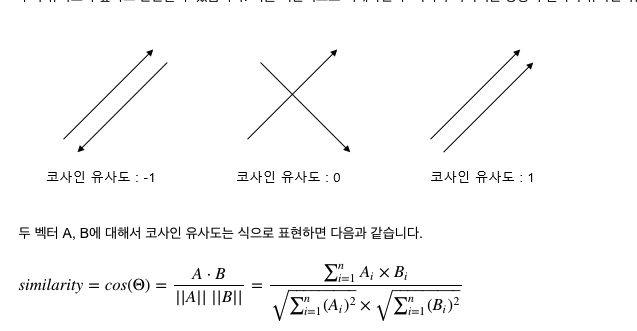

In [34]:
temp_list = []
final_list = []

for i in doctags:
    temp_cluster_i = []
    temp_cluster_for = []
    append_list = []
    if i[0] not in temp_list:
        temp_list.append(i[0])
        #print('base : '+ i[0])
        #i[0] 기준으로 유사도 0.2 이상
        for l in range (0, len(doc_vectorizer.docvecs.most_similar(i[0],topn=50))):
            if doc_vectorizer.docvecs.most_similar(i[0],topn=50)[l][1] >0.2:
                temp_list.append(doc_vectorizer.docvecs.most_similar(i[0],topn=50)[l][0])
                temp_cluster_i.append(doc_vectorizer.docvecs.most_similar(i[0],topn=50)[l][0])
                temp_cluster_for.append(doc_vectorizer.docvecs.most_similar(i[0],topn=50)[l][0])
        print(temp_cluster_for)   
        #유사도 0.2 이상인 list에서 추가 항목 찾기
        for j in temp_cluster_for:
            for k in range(0,len(doc_vectorizer.docvecs.most_similar(j,topn=50))):
                if doc_vectorizer.docvecs.most_similar(j,topn=50)[k][1] >0.2:
                    
                    temp_list.append(doc_vectorizer.docvecs.most_similar(j,topn=50)[k][0])
                    temp_cluster_i.append(doc_vectorizer.docvecs.most_similar(j,topn=50)[k][0])
    if len(temp_cluster_i) > 0:
        temp_set = set(temp_cluster_i) #집합set으로 변환
        append_list = list(temp_set) #list로 변환
        print(append_list)
        append_list.append(i[0])
        final_list.append(append_list)

[]
[]
[]
['1437', '1325']
['1437', '1325', '542']
[]
['1671']
['2412', '1671', '2396']
['710']
['710', '1425', '2360', '2579']
['852']
['978', '852', '1471']
['2762']
['1154', '415', '506', '1245', '2762']
['1480']
['1480', '918', '2713']
[]
[]
['1414', '2642']
['2699', '1414', '1871', '15', '2642']
['1730', '1310']
['1310', '2189', '1223', '2270', '1730']
['2085', '2363', '1594']
['1594', '2085', '306', '2010', '2363']
['1192']
['1053', '1192', '1177']
['735', '135', '2136']
['2136', '135', '735', '2507', '668']
[]
[]
['475']
['988', '475', '1004']
['1470']
['2153', '1930', '1470']
[]
[]
['1504']
['2163', '1504', '263']
[]
[]
['1578']
['1947', '1061', '1578']
[]
['151']
['158', '151']
['2803', '2']
['2803', '82', '643', '40', '2']
[]
['2168']
['2168', '490', '2062', '553']
[]
[]
['2015', '1804']
['1557', '654', '1804', '2650', '2015']
[]
['2209', '1982']
['2209', '21', '1218', '1973', '1982']
['1636']
['1636', '1315']
['1691', '807']
['1193', '807', '1691']
[]
[]
[]
['2422']
['2429', 

In [35]:
cluster_final_list = []
for i in range(0,len(final_list)):
    if len(final_list[i]) >= 1:
        #print(final_list[i])
        cluster_final_list.append(final_list[i])
        print(str(i) + ' : ' + str(len(final_list[i])))

0 : 4
1 : 4
2 : 5
3 : 4
4 : 6
5 : 4
6 : 6
7 : 6
8 : 6
9 : 4
10 : 6
11 : 4
12 : 4
13 : 4
14 : 4
15 : 3
16 : 6
17 : 5
18 : 6
19 : 6
20 : 3
21 : 4
22 : 4
23 : 8
24 : 3
25 : 5
26 : 4
27 : 5
28 : 4
29 : 3
30 : 3
31 : 4
32 : 3
33 : 4
34 : 3
35 : 7
36 : 4
37 : 6
38 : 5
39 : 3
40 : 4
41 : 3
42 : 7
43 : 3
44 : 6
45 : 3
46 : 5
47 : 3
48 : 4
49 : 3
50 : 3
51 : 4
52 : 3
53 : 4
54 : 4
55 : 4
56 : 8
57 : 3
58 : 3
59 : 3
60 : 4
61 : 3
62 : 7
63 : 7
64 : 5
65 : 3
66 : 7
67 : 4
68 : 5
69 : 4
70 : 3
71 : 4
72 : 3
73 : 5
74 : 4
75 : 4
76 : 5
77 : 5
78 : 3
79 : 3
80 : 4
81 : 7
82 : 8
83 : 6
84 : 4
85 : 4
86 : 3
87 : 7
88 : 3
89 : 5
90 : 3
91 : 3
92 : 5
93 : 5
94 : 3
95 : 4
96 : 4
97 : 3
98 : 5
99 : 3
100 : 6
101 : 3
102 : 6
103 : 3
104 : 3
105 : 4
106 : 3
107 : 3
108 : 3
109 : 4
110 : 5
111 : 4
112 : 3
113 : 5
114 : 4
115 : 3
116 : 4
117 : 5
118 : 3
119 : 4
120 : 3
121 : 3
122 : 5
123 : 3
124 : 4
125 : 4
126 : 4
127 : 3
128 : 4
129 : 6
130 : 4
131 : 4
132 : 3
133 : 4
134 : 4
135 : 4
136 : 6
137 : 4
138 : 

In [44]:
print(cluster_final_list[0])

['710', '1425', '2360', '2579', '2579']


In [45]:
df_raw[df_raw['index'].isin(cluster_final_list[0])][['index','title']]

,index,title
2579,2579,속보 스토킹처벌법 국회 본회의 통과 최대 징역 5년형
2360,2360,속보 북한 탄도미사일 발사 가능성
710,710,속보 15조원 규모 4차 재난지원금 추경안 본회의 통과
1425,1425,속보 삼척 원덕읍 기곡리 야산 주불 진화 잔불 정리중


In [32]:
docs1 = []
for i in range(0,len(df_merge)):
    docs.append(TaggedDocument(words=tokenizer(df_merge.iloc[i]['title']), tags=[df_merge.iloc[i]['index']]))

In [32]:
for i, doc in enumerate(docs):
    if i > 3: break
    print(doc)

In [32]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

In [32]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [32]:
from gensim.models import Doc2Vec


In [46]:
doc_vectorizer2 = Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=8,        # distance between the predicted word and context words
    vector_size=300, # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=7,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=cores,   # multi cpu
    hs = 1,          # hierarchical softmax / default 0
    negative = 10,   # negative sampling / default 5
)

In [47]:
doc_vectorizer2.build_vocab(docs)
print(str(doc_vectorizer2))


2021-03-27 04:53:32,787 : INFO : collecting all words and their counts
2021-03-27 04:53:32,791 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-03-27 04:53:32,864 : INFO : collected 11301 word types and 2815 unique tags from a corpus of 2815 examples and 347176 words
2021-03-27 04:53:32,867 : INFO : Loading a fresh vocabulary
2021-03-27 04:53:32,889 : INFO : effective_min_count=7 retains 8872 unique words (78% of original 11301, drops 2429)
2021-03-27 04:53:32,890 : INFO : effective_min_count=7 leaves 343552 word corpus (98% of original 347176, drops 3624)
2021-03-27 04:53:32,919 : INFO : deleting the raw counts dictionary of 11301 items
2021-03-27 04:53:32,920 : INFO : sample=0.001 downsamples 24 most-common words
2021-03-27 04:53:32,925 : INFO : downsampling leaves estimated 331734 word corpus (96.6% of prior 343552)
2021-03-27 04:53:32,937 : INFO : constructing a huffman tree from 8872 words
2021-03-27 04:53:33,140 : INFO : built huffman tree with

Doc2Vec(dbow+w,d300,n10,hs,w8,mc7,s0.001,t2)


In [48]:
import time
start = time.time()
for epoch in range(10):
    doc_vectorizer2.train(docs, total_examples=doc_vectorizer2.corpus_count, epochs=doc_vectorizer2.iter)
    doc_vectorizer2.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer2.min_alpha = doc_vectorizer2.alpha # fix the learning rate, no decay
end = time.time()
print("During Time: {}".format(end-start))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.
2021-03-27 04:53:35,376 : INFO : training model with 2 workers on 8872 vocabulary and 300 features, using sg=1 hs=1 sample=0.001 negative=10 window=8
2021-03-27 04:53:36,847 : INFO : EPOCH 1 - PROGRESS: at 8.53% examples, 19363 words/s, in_qsize 3, out_qsize 0
2021-03-27 04:53:38,321 : INFO : EPOCH 1 - PROGRESS: at 19.72% examples, 22399 words/s, in_qsize 4, out_qsize 0
2021-03-27 04:53:39,765 : INFO : EPOCH 1 - PROGRESS: at 31.62% examples, 23734 words/s, in_qsize 4, out_qsize 0
2021-03-27 04:53:41,162 : INFO : EPOCH 1 - PROGRESS: at 42.34% examples, 24544 words/s, in_qsize 4, out_qsize 0
2021-03-27 04:53:42,592 : INFO : EPOCH 1 - PROGRESS: at 54.00% examples, 25034 words/s, in_qsize 3, out_qsize 0
2021-03-27 04:53:43,941 : INFO : EPOCH 1 - PROGRESS: at 65.29% examples, 25506

During Time: 538.2802174091339


In [49]:
doctags = doc_vectorizer2.docvecs.doctags.items()
doctags = sorted(doctags, key=lambda x:x[1].offset)

In [53]:
temp_list = []
final_list2 = []

for i in doctags:
    temp_cluster_i = []
    temp_cluster_for = []
    append_list = []
    if i[0] not in temp_list:
        temp_list.append(i[0])
        #print('base : '+ i[0])
        #i[0] 기준으로 유사도 0.17 이상
        for l in range (0, len(doc_vectorizer2.docvecs.most_similar(i[0],topn=50))):
            if doc_vectorizer2.docvecs.most_similar(i[0],topn=50)[l][1] >0.5:
                temp_list.append(doc_vectorizer2.docvecs.most_similar(i[0],topn=50)[l][0])
                temp_cluster_i.append(doc_vectorizer2.docvecs.most_similar(i[0],topn=50)[l][0])
                temp_cluster_for.append(doc_vectorizer2.docvecs.most_similar(i[0],topn=50)[l][0])
        print(temp_cluster_for)   
        #유사도 0.17 이상인 list에서 추가 항목 찾기
        for j in temp_cluster_for:
            for k in range(0,len(doc_vectorizer2.docvecs.most_similar(j,topn=50))):
                if doc_vectorizer2.docvecs.most_similar(j,topn=50)[k][1] >0.5:
                    
                    temp_list.append(doc_vectorizer2.docvecs.most_similar(j,topn=50)[k][0])
                    temp_cluster_i.append(doc_vectorizer2.docvecs.most_similar(j,topn=50)[k][0])
    if len(temp_cluster_i) > 0:
        temp_set = set(temp_cluster_i) #집합set으로 변환
        append_list = list(temp_set) #list로 변환
        print(append_list)
        append_list.append(i[0])
        final_list2.append(append_list)

['22', '37', '12', '100', '109', '91', '55', '64', '82', '73']
['37', '64', '100', '12', '109', '55', '73', '82', '46', '91', '22']
['2583', '2544', '1296', '2558', '2518', '1944', '2571', '2577', '1270', '1927', '1243', '1981', '1962', '1234', '1918', '1935', '2551', '1304', '1971', '1288', '1909', '2565', '1899', '1261', '1225', '2536', '1953', '1279', '1252', '2527', '1661', '1842', '1806', '1824', '1796', '1694', '1673', '1642', '1778', '1860', '1534', '1787', '1769', '1832', '1679', '1686', '1702', '1851', '1667', '954']
['1918', '1496', '1288', '939', '1971', '1990', '2583', '954', '1953', '1667', '1261', '1270', '1505', '1549', '1304', '1944', '2577', '1778', '1824', '1642', '2571', '1679', '1527', '1488', '1769', '947', '1252', '2558', '2544', '2518', '1661', '1673', '1481', '1243', '1909', '1860', '962', '1534', '1981', '1842', '931', '2551', '1962', '1806', '1832', '1513', '1927', '1796', '1541', '1649', '1225', '2536', '1694', '1655', '1557', '1634', '1851', '1815', '1935', 

In [54]:
cluster_final_list2 = []
for i in range(0,len(final_list2)):
    if len(final_list2[i]) >= 3:
        #print(final_list[i])
        cluster_final_list2.append(final_list2[i])
        print(str(i) + ' : ' + str(len(final_list2[i])))

0 : 12
1 : 71
2 : 43
3 : 21
4 : 196
5 : 62
6 : 41
7 : 41
8 : 34
9 : 24
10 : 74
11 : 76
12 : 31
13 : 21
14 : 63
15 : 60
16 : 78
17 : 29
18 : 11
19 : 137
20 : 73
21 : 21
22 : 56
23 : 71
24 : 11
25 : 11
26 : 11
27 : 12
28 : 21
29 : 92
30 : 85
31 : 86
32 : 31
33 : 94
34 : 107
35 : 14
36 : 9
37 : 11
38 : 92
39 : 12
40 : 41
41 : 23
42 : 27
43 : 47
44 : 11
45 : 62
46 : 11
47 : 52
48 : 11
49 : 13
50 : 94
51 : 22
52 : 11
53 : 11
54 : 11
55 : 72
56 : 11
57 : 11
58 : 11
59 : 12
60 : 104
61 : 88
62 : 11
63 : 10
64 : 11
65 : 42
66 : 12
67 : 11
68 : 21
69 : 11
70 : 18
71 : 27
72 : 63
73 : 37
74 : 11
75 : 11
76 : 86
77 : 12
78 : 11
79 : 11
80 : 11
81 : 11
82 : 11
83 : 10
84 : 11
85 : 15
86 : 34
87 : 11
88 : 12
89 : 72
90 : 14
91 : 23
92 : 11
93 : 11
94 : 11
95 : 24
96 : 81
97 : 81
98 : 40
99 : 78
100 : 45
101 : 11
102 : 11
103 : 11
104 : 11
105 : 11
106 : 11
107 : 60
108 : 11
109 : 12
110 : 11
111 : 11
112 : 12
113 : 93
114 : 10
115 : 45
116 : 21
117 : 11
118 : 10
119 : 66
120 : 11
121 : 12
122 : 72


In [58]:
df_raw[df_raw['index'].isin(cluster_final_list2[2])][['index','title']]

,index,title
1335,1335,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다
2625,2625,속보 코로나19 신규 확진자 428명 다시 400명대로
831,831,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다
2610,2610,속보 코로나19 신규 확진자 428명 다시 400명대로
1318,1318,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다
442,442,속보 코로나19 신규 확진자 494명 나흘 연속 증가세
877,877,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다
397,397,속보 코로나19 신규 확진자 494명 나흘 연속 증가세
884,884,속보 코로나19 신규 확진자 430명 국내 확진자 10만명 넘었다
460,460,속보 코로나19 신규 확진자 494명 나흘 연속 증가세
